In [81]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

In [82]:
df = pd.read_csv('happiness.csv')

In [83]:
df

,Unnamed: 0,Country,Rank,HappinessScore,Family,GDP,HealthLifeExpectancy,Freedom,Trust_GovCorruption,Generosity,Year,continent
0,0,Switzerland,1,7.587,1.34951,1.39651,0.94143,0.66557,0.41978,0.29678,2015,Europe
1,1,Iceland,2,7.561,1.40223,1.30232,0.94784,0.62877,0.14145,0.43630,2015,Europe
2,2,Denmark,3,7.527,1.36058,1.32548,0.87464,0.64938,0.48357,0.34139,2015,Europe
3,3,Norway,4,7.522,1.33095,1.45900,0.88521,0.66973,0.36503,0.34699,2015,Europe
4,4,Canada,5,7.427,1.32261,1.32629,0.90563,0.63297,0.32957,0.45811,2015,North America
...,...,...,...,...,...,...,...,...,...,...,...,...
621,151,Yemen,152,3.355,1.07300,0.44200,0.34300,0.24400,0.06400,0.08300,2018,Asia
622,152,Tanzania,153,3.303,0.99100,0.45500,0.38100,0.48100,0.09700,0.27000,2018,Africa
623,153,South Sudan,154,3.254,0.60800,0.33700,0.17700,0.11200,0.10600,0.22400,2018,Africa
624,154,Central African Republic,155,3.083,0.00000,0.02400,0.01000,0.30500,0.03800,0.21800,2018,Africa


## EDA

#### 1. stripplot continents on Happiness

Text(0.5, 0, 'Continents')

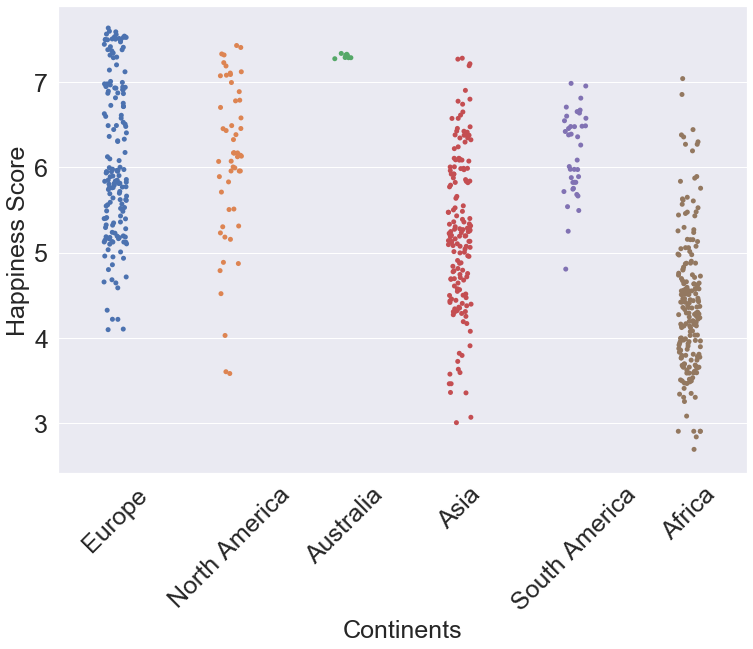

In [84]:
sns.set(rc={'figure.figsize':(11,8)})
sns.stripplot(x="continent", y="HappinessScore", data=df, jitter=True)
plt.xticks(rotation=45, size = 25)
plt.yticks(size =25)
plt.ylabel(ylabel = 'Happiness Score', size =25)
plt.xlabel(xlabel = 'Continents', size =25)

### 2. Barplot on continent on Happiness

Text(0.5, 0, 'Continents')

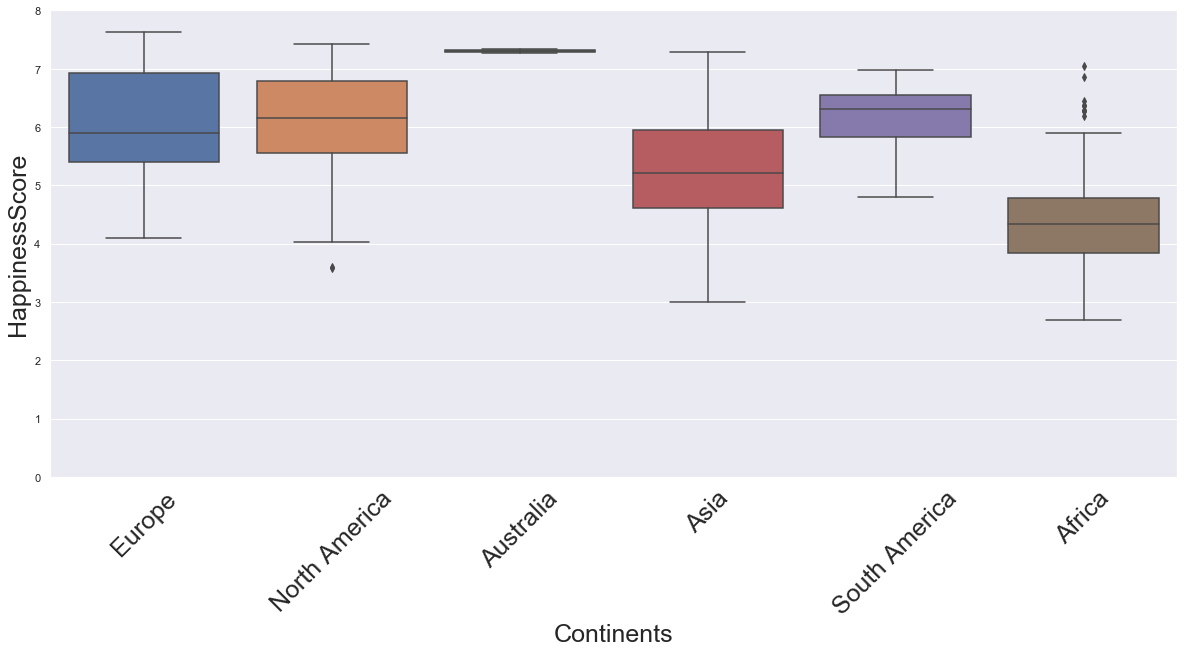

In [85]:
f, ax = plt.subplots(figsize=(18, 8))
fig = sns.boxplot(x='continent', y="HappinessScore", data = df)
fig.axis(ymin=0, ymax=8)
plt.xticks(rotation=45, size = 25)
plt.ylabel(ylabel = 'HappinessScore', size = 25)
plt.xlabel(xlabel = 'Continents',size = 25)

### 3. Plotly interactive map-  country on happiness

In [86]:
data = dict(type = 'choropleth', 
           locations = df['Country'],
           locationmode = 'country names',
           z = df['Rank'], 
           text = df['Country'],
           colorbar = {'title':'Rank'},
           colorscale = "blues")
layout = dict(title = 'Happiness Score From World Happiness Report Data From 2015-2018', 
             geo = dict(showframe = False, 
                       projection = {'type': 'mercator'}))
choromap = go.Figure(data = [data], layout=layout)
iplot(choromap)

### Selecting features

In [87]:
featureswithDV = ['HappinessScore', 'Family', 'GDP', 'HealthLifeExpectancy','Freedom', 'Trust_GovCorruption', 'Generosity']

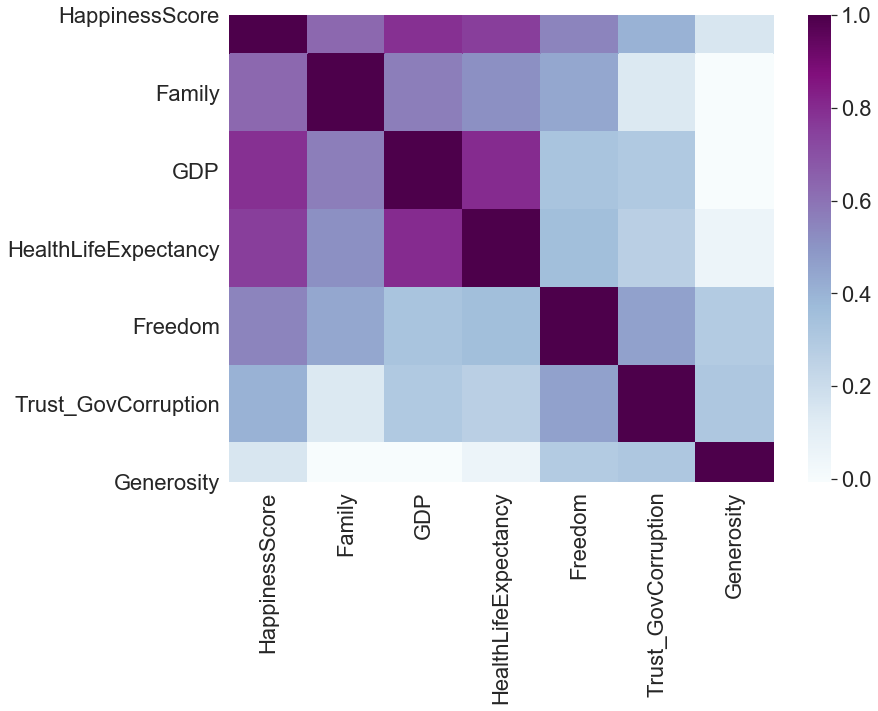

In [88]:
sns.set(rc={'figure.figsize':(11,8)})
sns.set(font_scale=2)
sns.heatmap(df[featureswithDV].corr(), cmap = "BuPu", square = True)

# Assumptions for Linear Regression
## Linearity
Linear regression requires that the relationship between the independent and dependent variables is linear. Let's use scatterplots and pair plots to check the relation of independent variables with the dependent variable, happiness score.

In [89]:
features = ['Family', 'GDP', 'HealthLifeExpectancy','Freedom', 'Trust_GovCorruption', 'Generosity']

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning:

The `size` parameter has been renamed to `height`; pleaes update your code.



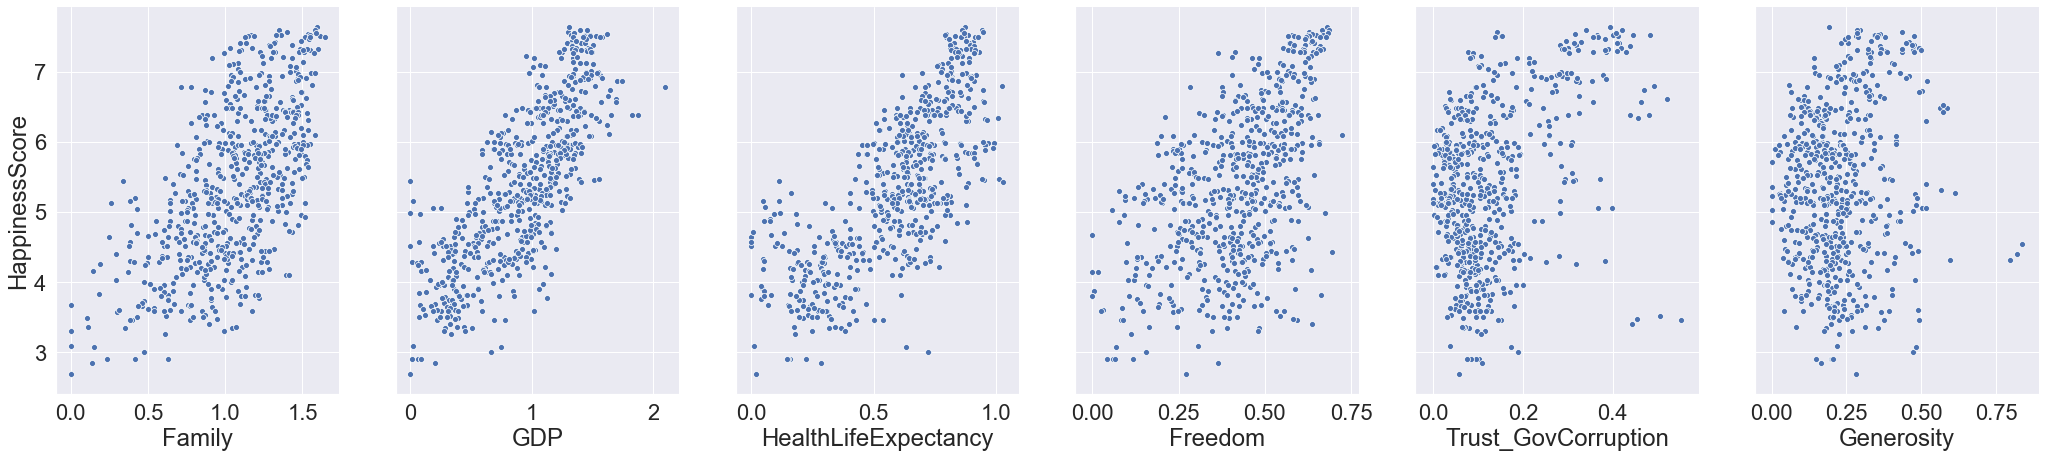

In [90]:
# visualize the relationship between the features and the response variable using scatterplots
p = sns.pairplot(df, x_vars=features, y_vars='HappinessScore', size=7, aspect=0.7)

[Text(0, 0.5, 'Happiness Score'), Text(0.5, 0, 'Variables')]

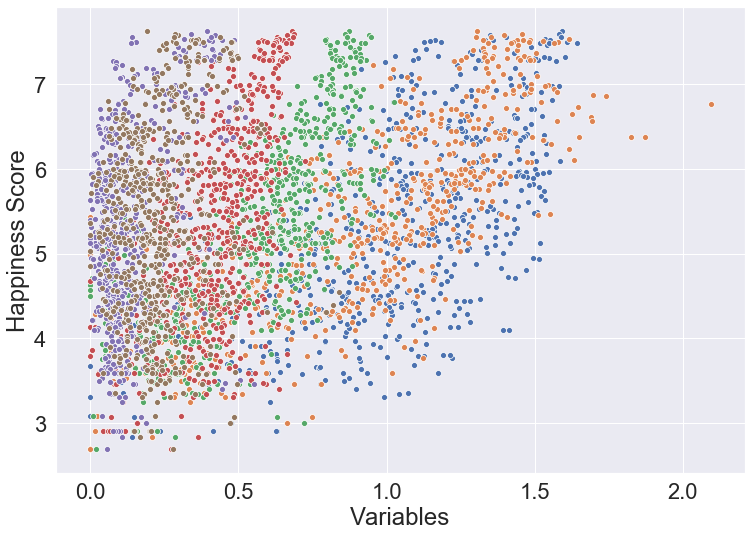

In [91]:
for col in df[features]:
    ax = sns.scatterplot(df[col], df['HappinessScore'])
ax.set(xlabel='Variables', ylabel='Happiness Score')

Our independent variables are all relatively linearly related to our dependent variables, Happiness Score.

## Normality in variables distributions

We examine the normality of all the variables.

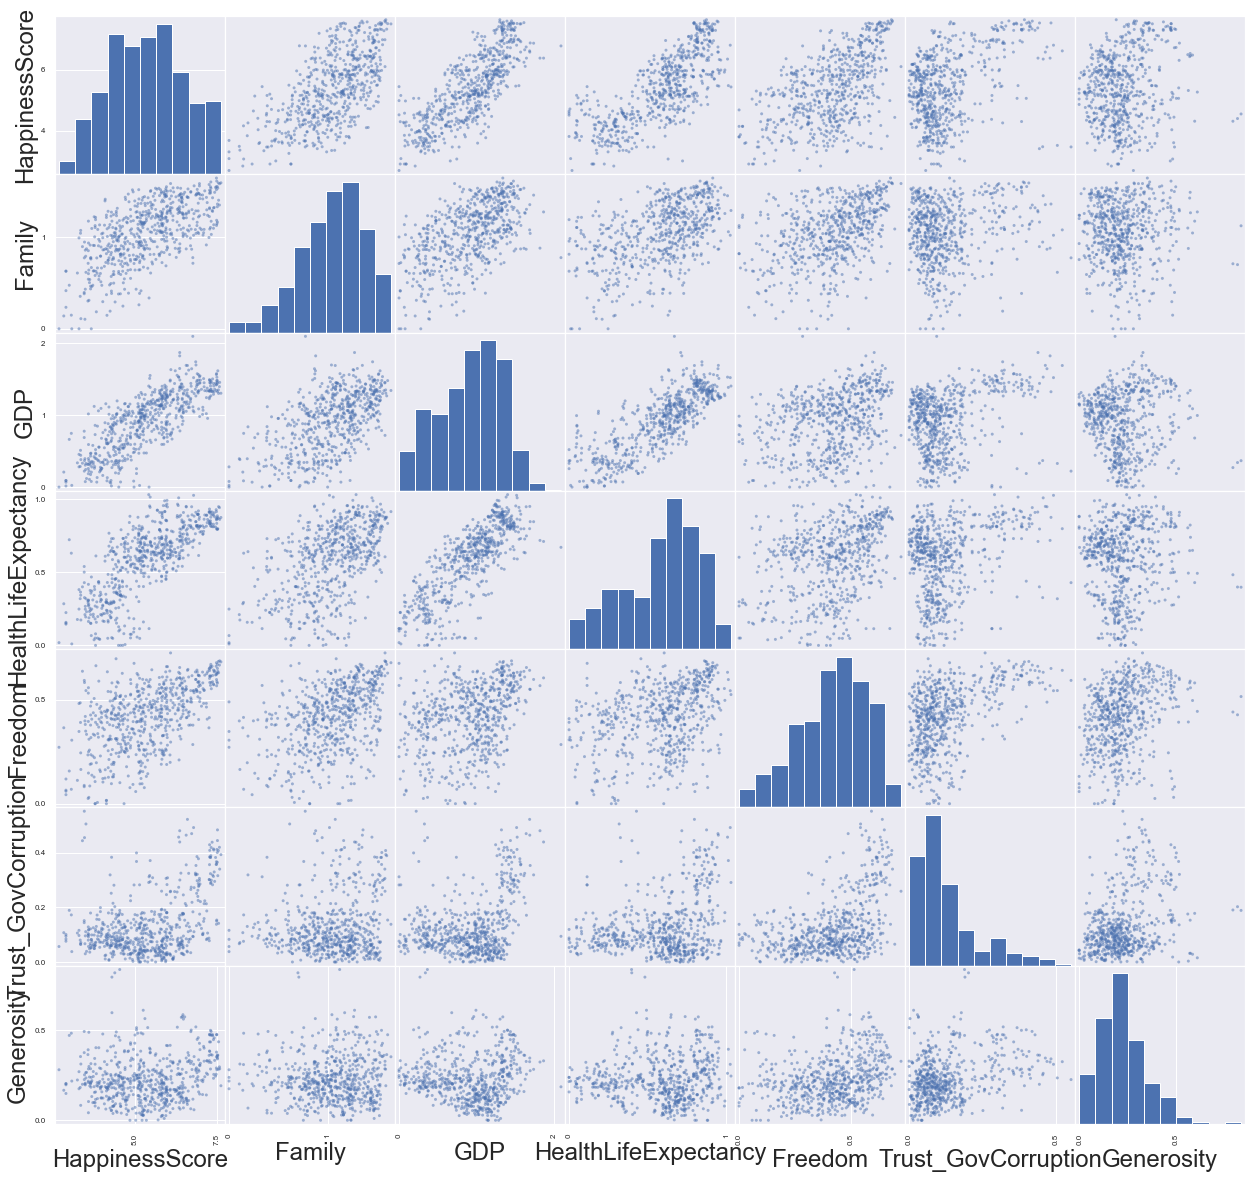

In [92]:
pd.plotting.scatter_matrix(df[featureswithDV], figsize=[19, 19]);

The distributions of Corruption and Generosity appear to be skewed to the right. 

### Log transformation on perception on corruption and generosity

In [93]:
df['Trust_GovCorruptionlog'] = df['Trust_GovCorruption'].map(lambda x: np.log(x))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

divide by zero encountered in log



In [94]:
df['Generositylog'] = df['Generosity'].map(lambda x: np.log(x))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

divide by zero encountered in log



Taking the log of zeroes results in some infinity values in our dataset, which we replace with 0.

In [155]:
df.replace([np.inf, -np.inf], 0, inplace=True)

## Base Regression Model

In [96]:
reg_mult = ols(formula = "HappinessScore~GDP+Family+HealthLifeExpectancy+Freedom+Trust_GovCorruption+Generosity",data=df)


In [97]:
model = reg_mult.fit()

In [98]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         HappinessScore   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     336.5
Date:                Mon, 02 Dec 2019   Prob (F-statistic):          4.01e-191
Time:                        12:51:33   Log-Likelihood:                -511.51
No. Observations:                 626   AIC:                             1037.
Df Residuals:                     619   BIC:                             1068.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.2029      0.087     25.271      0.000       2.032       2.374
GDP                      1.1032      0.097     11.402      0.000       0.913       1.293
Family                   0.6363      0.088      7.202      0.000       0.463       0.810
HealthLifeExpectancy     1.1385      0.155      7.324      0.000       0.833       1.444
Freedom                  1.4216      0.183      7.776      0.000       1.063       1.781
Trust_GovCorruption      0.8664      0.244      3.544      0.000       0.386       1.346
Generosity               0.5377      0.189      2.849      0.005       0.167       0.908
==============================================================================
Omnibus:                        9.468   Durbin-Watson:                   1.457
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               10.337
Skew:                          -0.227   Prob(JB):                      0.00569
Kurtosis:                       3.435   Cond. No.                         23.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Homoscedasticity
### QQ Plot


In [99]:
reg_mult = ols(formula = "HappinessScore~GDP+Family+HealthLifeExpectancy+Freedom+Trust_GovCorruption+Generosity",data=df)

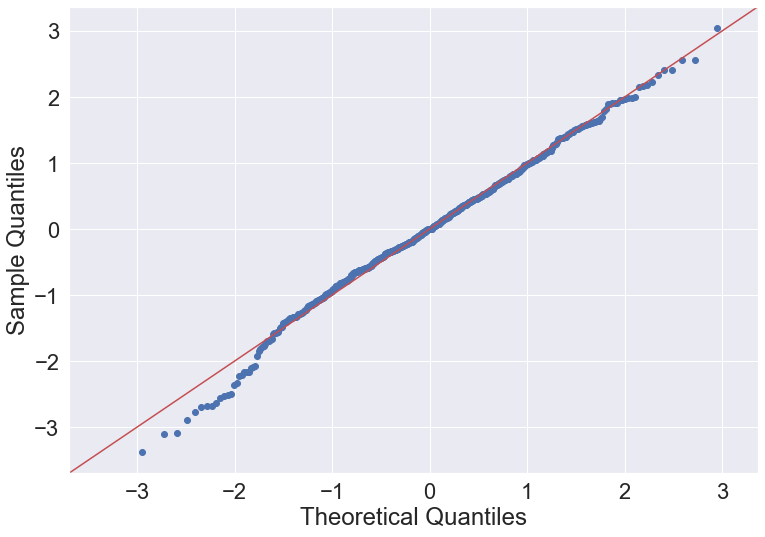

In [100]:
## Check the Homoscedasticity Assumption - qqplot
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)


### Residual plot


Homoscedasticity means that the residuals have equal or almost equal variance across the regression line. By plotting the error terms with predicted terms we can check that there is no pattern in the error terms.

In [101]:
model_fit = ols(formula="HappinessScore~GDP+Family+HealthLifeExpectancy+Freedom+Trust_GovCorruption+Generosity",
                data=df).fit()

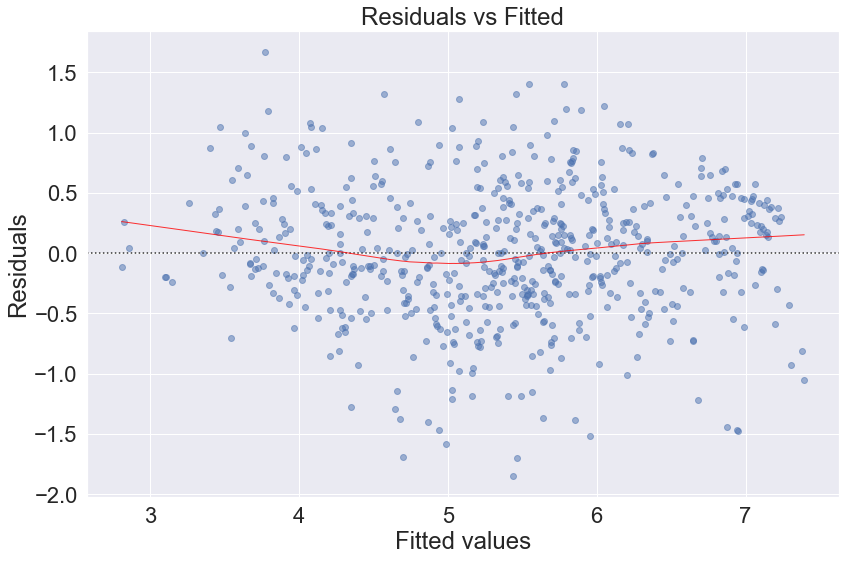

In [102]:
model_fitted_y = model_fit.fittedvalues

# model residuals
model_residuals = model_fit.resid

# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

plot_lm_1.axes[0] = sns.residplot(model_fitted_y, 'HappinessScore', data=df, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

# annotations
abs_resid = model_abs_resid.sort_values(ascending=False)
abs_resid_top_3 = abs_resid[:3]

# for i in abs_resid_top_3.index:
#     plot_lm_1.axes[0].annotate(i, 
#                                xy=(model_fitted_y[i], 
#                                    model_residuals[i]));


The first model does not severely violate the homoscadecity assumption.

## No Multicollinearity

VIF higher value indicates strong mulicollinearity.

In [103]:
# Function to calculate VIF
def calculate_vif(data):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    x_var_names = data.columns
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)

In [104]:
calculate_vif(df[features])

,Var,Vif
2,HealthLifeExpectancy,19.64
1,GDP,19.54
0,Family,15.49
3,Freedom,12.98
5,Generosity,4.32
4,Trust_GovCorruption,3.48


#### We decide to drop Health life expectancy because it violates the multicollinearity assumption as it is highly correlated with GDP, r>0.8.

## Stepwise Selection

We will look at a stepwise selection on data split into 70% training data/30% test data to assess features to include in the model.

In [105]:
X = df[['GDP','Freedom','Family','Trust_GovCorruptionlog','Generositylog']]
y = df.loc[:,'HappinessScore']

In [106]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [108]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

438 188 438 188


In [111]:
stepwiseresult = stepwise_selection(X_train, y_train, verbose=True)
print('resulting features:')
print(stepwiseresult)

Add  GDP                            with p-value 2.99689e-96
Add  Freedom                        with p-value 1.74038e-30
Add  Family                         with p-value 8.83886e-09
Add  Generositylog                  with p-value 0.000440547
Add  Trust_GovCorruptionlog         with p-value 0.00337976
resulting features:
['GDP', 'Freedom', 'Family', 'Generositylog', 'Trust_GovCorruptionlog']


In [112]:
train1, test1= train_test_split(df, test_size=0.3, random_state=0)


# Fitting Models

#### Model without Corruption:

In [115]:
reg_mult1 = ols(formula = "HappinessScore~GDP+Family+Freedom+Generositylog",data= train1).fit()
reg_mult1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         HappinessScore   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     326.9
Date:                Mon, 02 Dec 2019   Prob (F-statistic):          2.47e-129
Time:                        12:53:17   Log-Likelihood:                -368.13
No. Observations:                 438   AIC:                             746.3
Df Residuals:                     433   BIC:                             766.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.7142      0.123     22.101      0.000       2.473       2.956
GDP               1.6821      0.080     21.041      0.000       1.525       1.839
Family            0.6206      0.107      5.814      0.000       0.411       0.830
Freedom           1.7251      0.199      8.672      0.000       1.334       2.116
Generositylog     0.1484      0.041      3.603      0.000       0.067       0.229
==============================================================================
Omnibus:                        4.196   Durbin-Watson:                   2.151
Prob(Omnibus):                  0.123   Jarque-Bera (JB):                4.347
Skew:                          -0.145   Prob(JB):                        0.114
Kurtosis:                       3.392   Cond. No.                         19.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [116]:
y_hat_train = reg_mult1.predict(X_train)
y_hat_test = reg_mult1.predict(X_test)

In [117]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [118]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 0.3221628247479701
Test Mean Squared Error: 0.3522254604257883


In [119]:
rmse = np.sqrt(test_mse/len(X_test))
rmse

0.04328440461778232

Text(0, 0.5, 'Predicted Y')

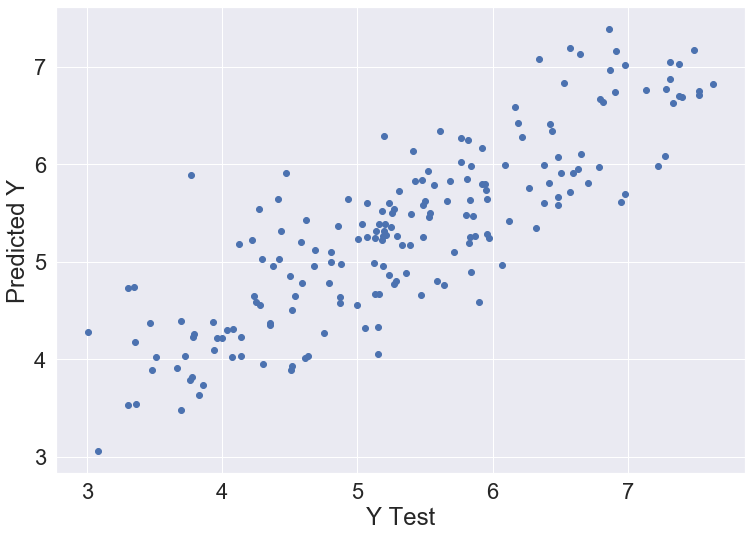

In [122]:
plt.scatter(y_test,y_hat_test)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [123]:
print('AIC for model exlcuding corruption:', reg_mult1.aic)
print('BIC for model excluding corruption:', reg_mult1.bic)

AIC for model exlcuding corruption: 746.2531467385511
BIC for model excluding corruption: 766.6642412904333


#### Model with Corruption:

In [124]:
reg_mult2 = ols(formula = "HappinessScore~GDP+Family+Freedom+Trust_GovCorruptionlog",data=train1).fit()
reg_mult2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         HappinessScore   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     326.8
Date:                Mon, 02 Dec 2019   Prob (F-statistic):          2.70e-129
Time:                        12:53:56   Log-Likelihood:                -368.22
No. Observations:                 438   AIC:                             746.4
Df Residuals:                     433   BIC:                             766.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2.7776      0.134     20.655      0.000       2.513       3.042
GDP                        1.6304      0.080     20.341      0.000       1.473       1.788
Family                     0.6379      0.107      5.936      0.000       0.427       0.849
Freedom                    1.6823      0.203      8.297      0.000       1.284       2.081
Trust_GovCorruptionlog     0.1110      0.031      3.577      0.000       0.050       0.172
==============================================================================
Omnibus:                        8.580   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.014   Jarque-Bera (JB):               10.541
Skew:                          -0.207   Prob(JB):                      0.00514
Kurtosis:                       3.637   Cond. No.                         24.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [125]:
y_hat_train = reg_mult2.predict(X_train)
y_hat_test = reg_mult2.predict(X_test)

In [126]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [127]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 0.3221731106813105
Test Mean Squared Error: 0.3487548552060704


In [128]:
rmse = np.sqrt(test_mse/len(X_test))
rmse

0.04307062824075783

Text(0, 0.5, 'Predicted Y')

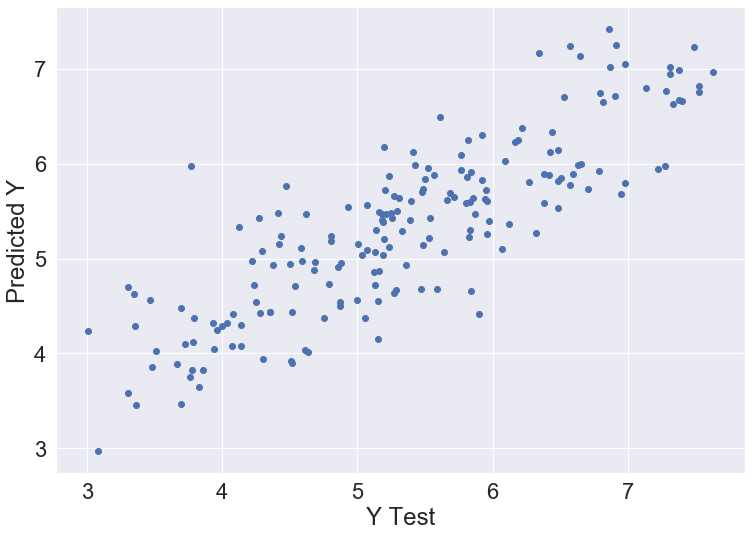

In [131]:
plt.scatter(y_test,y_hat_test)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [132]:
print('AIC for model:', reg_mult2.aic)
print('BIC for model:', reg_mult2.bic)

AIC for model: 746.433043274658
BIC for model: 766.8441378265402


## Regression with Continent - categorical variables

In [144]:
reg_mult_con = ols(formula = "HappinessScore~GDP+Family+Freedom+Trust_GovCorruption+continent",data=train1).fit()
reg_mult_con.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         HappinessScore   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     221.1
Date:                Mon, 02 Dec 2019   Prob (F-statistic):          2.67e-166
Time:                        12:55:13   Log-Likelihood:                -358.08
No. Observations:                 500   AIC:                             736.2
Df Residuals:                     490   BIC:                             778.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      2.6340      0.084     31.393      0.000       2.469       2.799
continent[T.Asia]              0.1231      0.067      1.827      0.068      -0.009       0.255
continent[T.Australia]         0.8431      0.239      3.526      0.000       0.373       1.313
continent[T.Europe]            0.5062      0.078      6.461      0.000       0.352       0.660
continent[T.North America]     0.8079      0.093      8.646      0.000       0.624       0.991
continent[T.South America]     0.8706      0.104      8.339      0.000       0.665       1.076
GDP                            1.3239      0.081     16.273      0.000       1.164       1.484
Family                         0.4174      0.091      4.580      0.000       0.238       0.596
Freedom                        1.4364      0.182      7.913      0.000       1.080       1.793
Trust_GovCorruption            1.4487      0.248      5.845      0.000       0.962       1.936
==============================================================================
Omnibus:                       11.172   Durbin-Watson:                   2.147
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               15.580
Skew:                          -0.196   Prob(JB):                     0.000414
Kurtosis:                       3.771   Cond. No.                         22.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [163]:
train1, test1= train_test_split(df, test_size=0.3, random_state=0)

### Create dummy variables for continents

In [164]:
df_with_dummies = pd.get_dummies(df, prefix='continent', columns=['continent'])
df_with_dummies = df_with_dummies.rename(columns={'continent_North America': 'continent_North_America', 
                                   'continent_South America': 'continent_South_America'})

In [165]:
X4 = df_with_dummies[['GDP','Freedom','Family','Trust_GovCorruption','Generosity','continent_Africa', 'continent_Asia', 'continent_Australia',
       'continent_Europe', 'continent_North_America',
       'continent_South_America']]
y4 = df_with_dummies.loc[:,'HappinessScore']

train2, test2= train_test_split(df_with_dummies, test_size=0.2, random_state=0)


In [166]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.3, random_state=42)

In [167]:
reg_with_continent = ols(formula="HappinessScore~GDP+Family+Freedom+Trust_GovCorruption+continent_Asia+continent_Australia+continent_Europe+continent_North_America+continent_South_America",data=train2).fit()
reg_with_continent.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         HappinessScore   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     221.1
Date:                Mon, 02 Dec 2019   Prob (F-statistic):          2.67e-166
Time:                        13:15:09   Log-Likelihood:                -358.08
No. Observations:                 500   AIC:                             736.2
Df Residuals:                     490   BIC:                             778.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   2.6340      0.084     31.393      0.000       2.469       2.799
GDP                         1.3239      0.081     16.273      0.000       1.164       1.484
Family                      0.4174      0.091      4.580      0.000       0.238       0.596
Freedom                     1.4364      0.182      7.913      0.000       1.080       1.793
Trust_GovCorruption         1.4487      0.248      5.845      0.000       0.962       1.936
continent_Asia              0.1231      0.067      1.827      0.068      -0.009       0.255
continent_Australia         0.8431      0.239      3.526      0.000       0.373       1.313
continent_Europe            0.5062      0.078      6.461      0.000       0.352       0.660
continent_North_America     0.8079      0.093      8.646      0.000       0.624       0.991
continent_South_America     0.8706      0.104      8.339      0.000       0.665       1.076
==============================================================================
Omnibus:                       11.172   Durbin-Watson:                   2.147
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               15.580
Skew:                          -0.196   Prob(JB):                     0.000414
Kurtosis:                       3.771   Cond. No.                         22.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [169]:
y_hat_train = reg_with_continent.predict(X_train4)
y_hat_test = reg_with_continent.predict(X_test4)

In [170]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [171]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 0.2566059461135139
Test Mean Squared Error: 0.2659444713961214


In [172]:
rmse = np.sqrt(test_mse/len(X_test))
rmse

0.037611145317671846

Text(0, 0.5, 'Predicted Y')

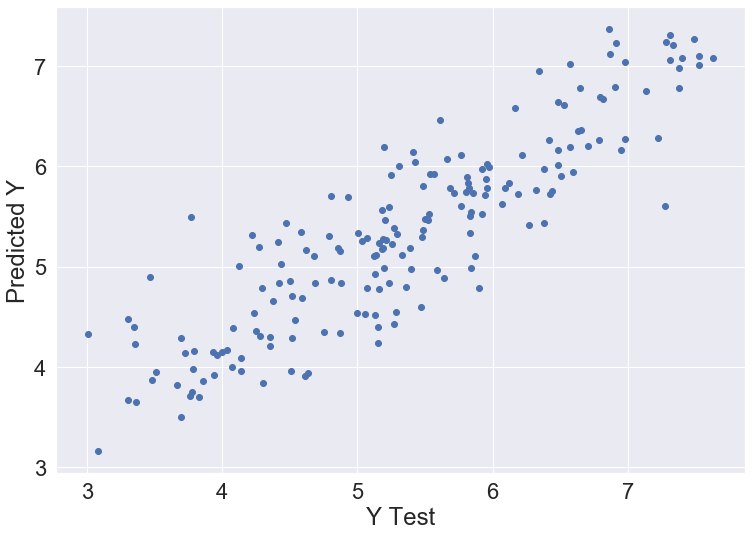

In [173]:
plt.scatter(y_test,y_hat_test)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [174]:
print('AIC for final model:', reg_with_continent.aic)
print('BIC for final model:', reg_with_continent.bic)

AIC for final model: 736.1514061003055
BIC for final model: 778.2974870845275


**Final model AIC dropped from 1033 to 736, and R squared increased to 80%, indicating it is a better model compared to the others.**


### Visualize training testing error

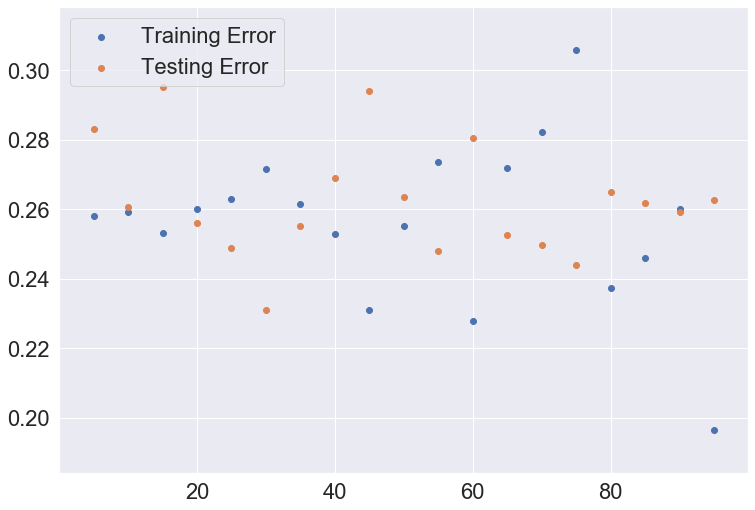

In [175]:
import random
random.seed(11)
linreg = LinearRegression()
train_err = []
test_err = []
t_sizes = list(range(5,100,5)) 
for t_size in t_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X4, y4, test_size=t_size/100)
    linreg.fit(X_train, y_train)
    y_hat_train = reg_with_continent.predict(X_train)
    y_hat_test = reg_with_continent.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend()

# Testing Ridge & Lasso application

In [199]:
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.preprocessing import MinMaxScaler

In [200]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.3, random_state=42)

In [201]:
scale = MinMaxScaler()
X_train_transformed = scale.fit_transform(X_train4)
X_test_transformed = scale.transform(X_test4)

In [202]:
# Build a Ridge, Lasso and regular linear regression model  
# Note that in scikit-learn, the regularization parameter is denoted by alpha (and not lambda)
ridge = Ridge(alpha=0.5)
ridge.fit(X_train_transformed, y_train4)

lasso = Lasso(alpha=0.5)
lasso.fit(X_train_transformed, y_train4)

lin = LinearRegression()
lin.fit(X_train_transformed, y_train4)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [203]:
# Generate preditions for training and test sets
y_h_ridge_train = ridge.predict(X_train_transformed)
y_h_ridge_test = ridge.predict(X_test_transformed)

y_h_lasso_train = np.reshape(lasso.predict(X_train_transformed), (438, 1))
y_h_lasso_test = np.reshape(lasso.predict(X_test_transformed), (188, 1))

y_h_lin_train = lin.predict(X_train_transformed)
y_h_lin_test = lin.predict(X_test_transformed)

In [204]:
print('Train Error Ridge Model', np.sum((y_train4 - y_h_ridge_train)**2))
print('Test Error Ridge Model', np.sum((y_test4 - y_h_ridge_test)**2))
print('\n')

print('Train Error Lasso Model', np.sum((y_train4 - y_h_lasso_train)**2))
print('Test Error Lasso Model', np.sum((y_test4 - y_h_lasso_test)**2))
print('\n')

print('Train Error Unpenalized Linear Model', np.sum((y_train4 - lin.predict(X_train_transformed))**2))
print('Test Error Unpenalized Linear Model', np.sum((y_test4 - lin.predict(X_test_transformed))**2))

Train Error Ridge Model 109.99984979089308
Test Error Ridge Model 49.78352114502145




Exception: Data must be 1-dimensional

Our model was not improved by utilizing the Ridge or Lasso methods given that the least error results from the Unpenalized Linear Model.